# Cluster_3 Stacking Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import joblib

## Load Dataset

In [2]:
df = pd.read_csv('data/train_cluster3.csv')
X = df.drop(columns=['Bankrupt?', 'Index'])
y = df['Bankrupt?']

## Subgroup Statistics

In [3]:
print('Total companies:', len(df))
print('Bankrupt count:', y.sum())
print('Non-bankrupt count:', len(df)-y.sum())

Total companies: 2157
Bankrupt count: 82
Non-bankrupt count: 2075


## Preprocessing (Scaling + PCA)

In [4]:
scaler = StandardScaler()
pca = PCA(n_components=13, random_state=42)

## Base Models

In [5]:
base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=6, class_weight='balanced', random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=200, random_state=42)),
    ('mlp', MLPClassifier(hidden_layer_sizes=(64,), activation='relu', solver='adam', alpha=0.001, max_iter=800, random_state=42)),
    ('hgb', HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, random_state=42))
]

## Meta Model

In [6]:
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.05)

## Stacking Model

In [7]:
stack_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    stack_method='predict_proba'
)

## Pipeline

In [8]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('stack', stack_model)
])

## Train Model

In [9]:
pipeline.fit(X, y)

,steps,"[('scaler', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,13
,copy,True
,whiten,False
,svd_solver,'auto'


## Compute ROC-AUC

In [10]:
y_prob = pipeline.predict_proba(X)[:,1]
print('Stacked ROC-AUC:', roc_auc_score(y, y_prob))

Stacked ROC-AUC: 0.9999471054951513


## Threshold Sweep

In [11]:
def threshold_sweep(y_true, y_prob, thresholds=np.arange(0.1, 0.91, 0.1)):
    results = []
    for t in thresholds:
        y_pred_thresh = (y_prob >= t).astype(int)
        cm = confusion_matrix(y_true, y_pred_thresh, labels=[1,0])
        TT, FN = cm[0,0], cm[0,1]
        FP, TN = cm[1,0], cm[1,1]
        recall = TT / (TT + FN) if (TT+FN) > 0 else 0
        precision = TT / (TT + FP) if (TT+FP) > 0 else 0
        results.append((t, TT, FN, FP, TN, precision, recall))
    return results

sweep_results = threshold_sweep(y, y_prob)
print(sweep_results[:3])

[(np.float64(0.1), np.int64(82), np.int64(0), np.int64(2075), np.int64(0), np.float64(0.03801576263328697), np.float64(1.0)), (np.float64(0.2), np.int64(82), np.int64(0), np.int64(2075), np.int64(0), np.float64(0.03801576263328697), np.float64(1.0)), (np.float64(0.30000000000000004), np.int64(82), np.int64(0), np.int64(2075), np.int64(0), np.float64(0.03801576263328697), np.float64(1.0))]


## Find Best Threshold

In [12]:
best = max([r for r in sweep_results if r[6] >= 0.80], key=lambda x: x[5])
best_threshold, best_TT, best_FN, best_FP, best_TN, best_precision, best_recall = best
print(best_threshold)

0.9


## Confusion Matrix at Best Threshold

In [13]:
y_pred_best = (y_prob >= best_threshold).astype(int)
cm_best = confusion_matrix(y, y_pred_best, labels=[1,0])
print(cm_best)

[[  74    8]
 [   0 2075]]


## Plot Threshold Metrics

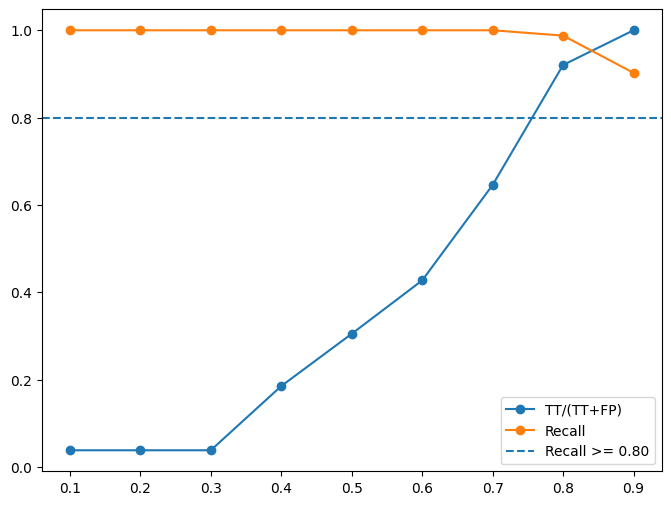

In [14]:
precisions = [r[5] for r in sweep_results]
recalls = [r[6] for r in sweep_results]
thresholds = [r[0] for r in sweep_results]

plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, marker='o', label='TT/(TT+FP)')
plt.plot(thresholds, recalls, marker='o', label='Recall')
plt.axhline(y=0.80, linestyle='--', label='Recall >= 0.80')
plt.legend()
plt.show()

## Evaluate Base Models

In [15]:
X_proc = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_proc)

models = {
    'Random Forest': base_estimators[0][1],
    'Gradient Boosting': base_estimators[1][1],
    'MLP': base_estimators[2][1],
    'HGB': base_estimators[3][1]
}

for name, model in models.items():
    model.fit(X_pca, y)
    y_prob_base = model.predict_proba(X_pca)[:,1]
    y_pred_base = (y_prob_base >= best_threshold).astype(int)
    cm = confusion_matrix(y, y_pred_base, labels=[1,0])
    print(f"\n{name}")
    print(cm)


Random Forest
[[   6   76]
 [   0 2075]]

Gradient Boosting
[[  21   61]
 [   0 2075]]

MLP
[[  35   47]
 [   0 2075]]

HGB
[[  82    0]
 [   0 2075]]


## Final Meta Model Results

In [16]:
print(cm_best)

[[  74    8]
 [   0 2075]]


In [18]:
joblib.dump(pipeline, 'models/subgroup3_cluster3_model.joblib')

['models/subgroup3_cluster3_model.joblib']